In [1]:
import tensorflow           as tf
import matplotlib.pyplot    as plt

from keras.applications             import VGG19
from keras.models                   import Sequential, load_model
from keras.layers                   import Dense, Flatten, Dropout
from keras.optimizers               import Adam
from keras.preprocessing.image      import ImageDataGenerator
from tensorflow.keras.callbacks     import ModelCheckpoint
from tensorflow.keras.regularizers  import l2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from pathlib import Path

import pandas               as pd
import seaborn              as sns
import tensorflow           as tf
import numpy                as np
import matplotlib.pyplot    as plt
import shutil
import splitfolders
import os

Configurar TensorFlow para usar la GPU

In [2]:
# Configurar TensorFlow para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Elimina y recrea directorio split_imagenes, divide imágenes en carpetas de entrenamiento y validación

In [3]:
transformada = "cgau1"

#Ruta al directoria split_imagenes
ruta_imagenes = Path(f"../../../../imagenes/{transformada}")
ruta_split_imagenes = Path(f"../../../../split_imagenes/{transformada}")

#Si el directorio ya existe, eliminarlo junto con su contendio
if ruta_split_imagenes.exists():
    shutil.rmtree(ruta_split_imagenes)

#Crear el split de las imágenes de la transformada
splitfolders.ratio(input=ruta_imagenes, output=ruta_split_imagenes, ratio=(.8,.2))

Copying files: 4000 files [00:16, 245.32 files/s]


Se definen parámetros

In [4]:
# Definir rutas de las carpetas que contienen las imágenes
img_width, img_height   = 250, 250
input_shape             = (img_width, img_height, 3)

# Hiperparámetros
epochs      = 100
batch_size  = 16

Se crean los generadores de datos de imágenes

In [5]:
# Configurar el generador de datos de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagem = ImageDataGenerator(rescale=1./255)

# Cargar y dividir los datos en conjuntos de entrenamiento y prueba
generador_entrenamiento = train_datagen.flow_from_directory(
    ruta_split_imagenes/"train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Cargar imágenes de validación
generador_validacion = valid_datagem.flow_from_directory(
    ruta_split_imagenes/"val",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Se carga el modelo preentrenado

In [6]:
# Cargar el modelo ResNet50 pre-entrenado sin la parte superior (include_top = False)
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas de la ResNet50 pre-entrenada
for layer in vgg19_model.layers:
    layer.trainable = False

Se agregan capas al final del modelo

In [7]:
# Construir el modelo
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(
    optimizer   = Adam(learning_rate=0.001),
    loss        = 'binary_crossentropy',
    metrics     = ['accuracy']
)

Entrenamiento del modelo

In [8]:
#Se define un callback para guardar el mejor modelo basado en el val_accuracy
checkpoint_callback = ModelCheckpoint(
    filepath = "modelo_generado/mejor_modelo.keras",
    monitor = "val_accuracy",
    save_best_only = True,
    mode = "max",
    verbose = 1
)

# Entrenar el modelo
historia = model.fit(
    generador_entrenamiento,
    steps_per_epoch=generador_entrenamiento.samples // batch_size,
    epochs=epochs,
    validation_data=generador_validacion,
    validation_steps=generador_validacion.samples // batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.6672
Epoch 1: val_accuracy improved from -inf to 0.65625, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 96s 432ms/step - loss: 0.7510 - accuracy: 0.6672 - val_loss: 0.5923 - val_accuracy: 0.6562
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7303
Epoch 2: val_accuracy improved from 0.65625 to 0.78250, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 36s 180ms/step - loss: 0.5383 - accuracy: 0.7303 - val_loss: 0.5104 - val_accuracy: 0.7825
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7678
Epoch 3: val_accuracy improved from 0.78250 to 0.81250, saving model to modelo_generado\mejor_modelo.keras
200/200 [==============================] - 36s 182ms/step - loss: 0.4901 - accuracy: 0.7678 - val_loss: 0.4474 - val_accura

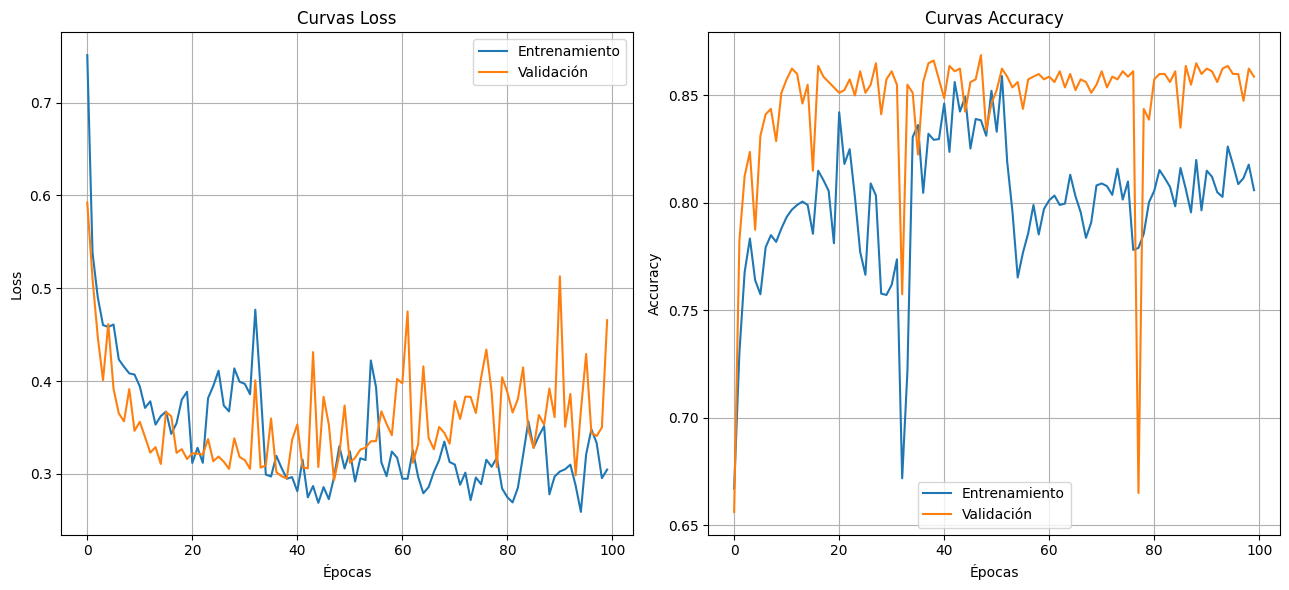

In [9]:
# Curvas de pérdida
plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.plot(historia.history['loss'], label='Entrenamiento')
plt.plot(historia.history['val_loss'], label='Validación')
plt.title('Curvas Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(historia.history['accuracy'], label='Entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Validación')
plt.title('Curvas Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Parte 5:** Evaluación del modelo

Se evalua el mejor modelo guardado

In [10]:
mejor_modelo = load_model("modelo_generado/mejor_modelo.keras")
generador_validacion.reset()
resul_eva = mejor_modelo.evaluate(generador_validacion, verbose=False)

# Obtener los resultados de pérdida y accuracy
perdida = resul_eva[0]
accuracy = resul_eva[1]

print("Loss: {:.2f}".format(perdida))
print("Accuracy: {:.2%}".format(accuracy))

#Crear un Dataframe con los nuevos resultados
new_data = pd.DataFrame({"Loss":[perdida], "Accuracy":[accuracy]})

#Especificar el nombre del archivo Excel
file_name = "resultados_iteraciones/resultados.xlsx"

#Verificar si el archivo ya existe
if os.path.exists(file_name):
    #Si el archivo existe, cargar los datos existentes
    existing_data = pd.read_excel(file_name, sheet_name="Resultados")
    #Concatenar los datos existentes con los nuevos datos
    df = pd.concat([existing_data, new_data], ignore_index=True)
else:
    #Si el archivo no existe, usar solo los nuevos datos
    df = new_data

#Guardar el Dataframe en el archivo Excel
df.to_excel(file_name, sheet_name="Resultados", index=False)

Loss: 0.29
Accuracy: 86.87%


Cálculo de diferentes métricas


Matriz de Confusión:


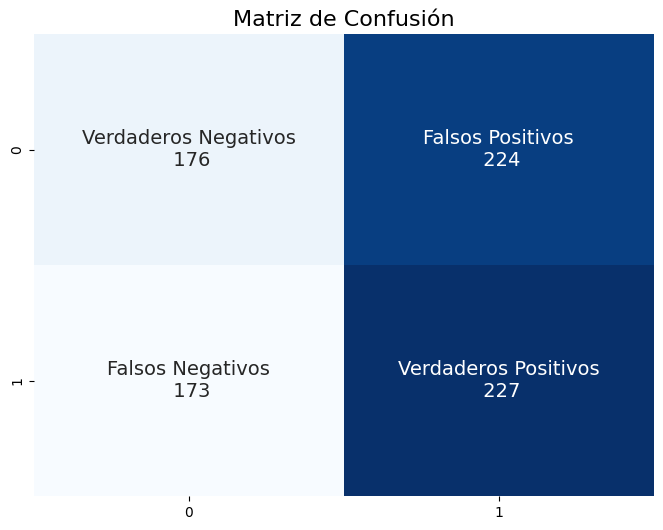

Accuracy:	50.38%
Sensitivity:	56.75%
Specificity:	44.00%
Precision:	50.33%
F1-score:	53.35%


In [11]:
# Obtener las predicciones del modelo
y_pred_prob = mejor_modelo.predict(generador_validacion, verbose=False)

# Convertir las probabilidades en clases binarias usando un umbral (por ejemplo, 0.85)
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtener las etiquetas verdaderas
y_test = generador_validacion.classes

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calcular sensitivity y specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Imprimir resultados
print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Sensitivity:\t{:.2%}".format(sensitivity))
print("Specificity:\t{:.2%}".format(specificity))
print("Precision:\t{:.2%}".format(precision))
print("F1-score:\t{:.2%}".format(f1))